Epoch 1/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3924 - loss: 1.7536 - val_accuracy: 0.5874 - val_loss: 0.9356
Epoch 2/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5820 - loss: 0.9484 - val_accuracy: 0.6676 - val_loss: 0.7991
Epoch 3/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6504 - loss: 0.8171 - val_accuracy: 0.7273 - val_loss: 0.7197
Epoch 4/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7072 - loss: 0.7269 - val_accuracy: 0.7809 - val_loss: 0.6187
Epoch 5/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7379 - loss: 0.6587 - val_accuracy: 0.8048 - val_loss: 0.5687
Epoch 6/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7587 - loss: 0.6089 - val_accuracy: 0.7846 - val_loss: 0.5851
Epoch 7/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7833 - loss: 0.5690 - val_accuracy: 0.8259 - val_loss: 0.5052
Epoch 8/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7950 - loss: 0.5474 - val_accu

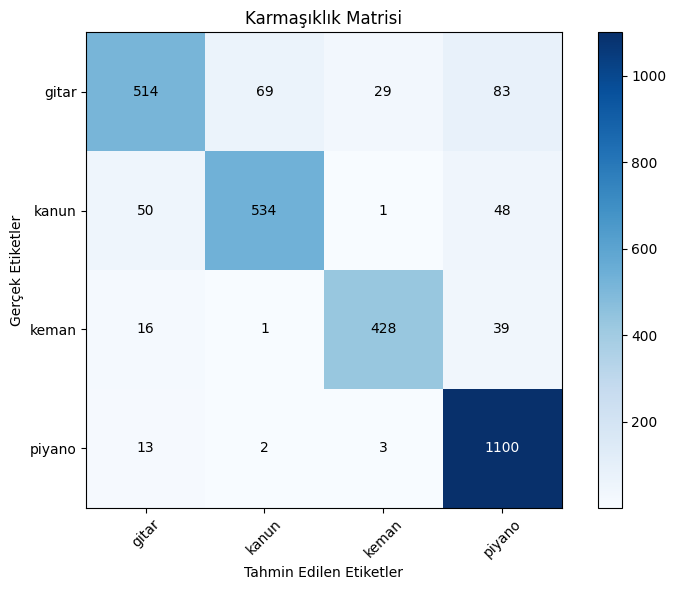

Karmaşıklık Matrisi:
[[ 514   69   29   83]
 [  50  534    1   48]
 [  16    1  428   39]
 [  13    2    3 1100]]


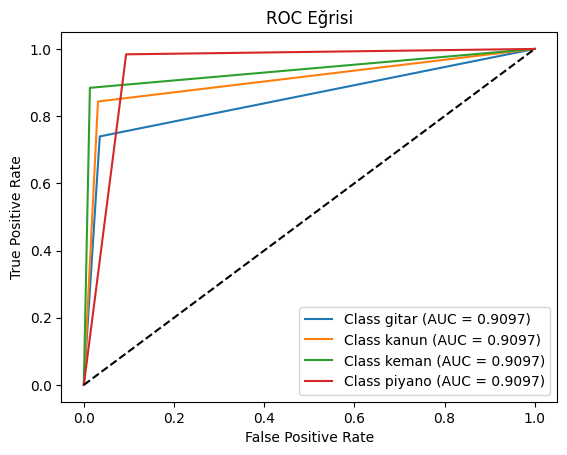

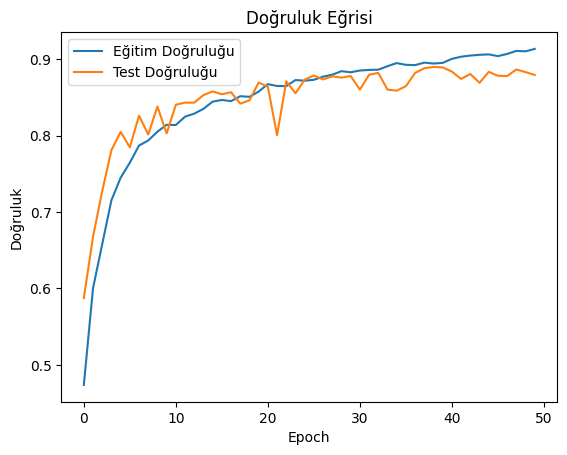

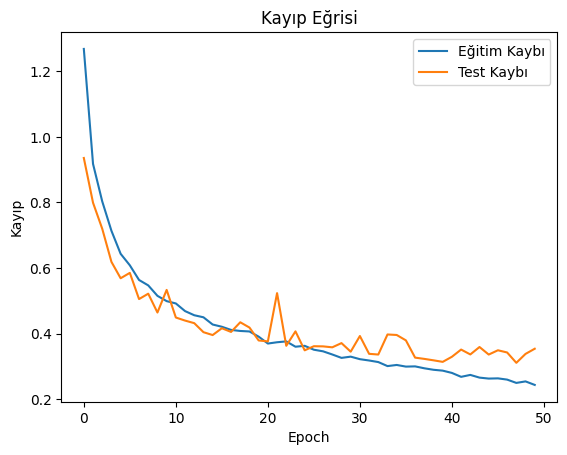

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Çıkarım süresi: 0.3522 saniye
Eğitim süresi: 225.0066 saniye


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, matthews_corrcoef, cohen_kappa_score
import matplotlib.pyplot as plt
import time

# Klasör isimleri ve etiketler
enstruman_klasorleri = {
    "mfcc_cikti_gitar": "gitar",
    "mfcc_cikti_kanun": "kanun",
    "mfcc_cikti_keman": "keman",
    "mfcc_cikti_piyano": "piyano"
}

# Ana dizinin yolu
ana_dizin = r"C:\Users\Buse Yener\makineProje"

# Maksimum kare sayısını belirleme
TARGET_SHAPE = (100, 13)  # 100 zaman adımı, 13 MFCC katsayısı

# Veriyi hazırlama
X = []
y = []

for klasor, etiket in enstruman_klasorleri.items():
    klasor_yolu = os.path.join(ana_dizin, klasor)
    for dosya in os.listdir(klasor_yolu):
        dosya_yolu = os.path.join(klasor_yolu, dosya)
        
        # MFCC verisini yükleme
        mfcc_verisi = np.load(dosya_yolu)
        
       
        
        # MFCC öznitelik sayısının uyumlu olup olmadığını kontrol etme (13 öznitelik )
        assert mfcc_verisi.shape[0] == 13 
        
        # Zaman adımlarını hedef şekle uyarlama
        if mfcc_verisi.shape[1] > TARGET_SHAPE[0]:
            # Zaman adımları fazla ise, fazlalıkları kes
            mfcc_verisi = mfcc_verisi[:, :TARGET_SHAPE[0]]
        elif mfcc_verisi.shape[1] < TARGET_SHAPE[0]:
            # Zaman adımları eksikse, baştan padleme yap
            mfcc_verisi = np.pad(mfcc_verisi, ((0, 0), (0, TARGET_SHAPE[0] - mfcc_verisi.shape[1])), mode='constant')
        
        # Özellik ve etiketleri ekleme
        X.append(mfcc_verisi)
        y.append(etiket)

# Veriyi numpy dizilerine dönüştürme
X = np.array(X)
y = np.array(y)

# Etiketleri sayısal hale getirme
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Veriyi eğitim ve test kümelerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Conformer Modeli
input_layer = keras.Input(shape=(TARGET_SHAPE[1], TARGET_SHAPE[0], 1))
x = layers.Reshape((TARGET_SHAPE[0], TARGET_SHAPE[1], 1))(input_layer)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
output_layer = layers.Dense(len(label_encoder.classes_), activation="softmax")(x)

model = keras.Model(input_layer, output_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])


# Model eğitim süreci
start_time = time.time()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
training_time = time.time() - start_time

# Tahmin yapma
y_pred = np.argmax(model.predict(X_test), axis=1)

# Performans metriklerini hesaplama
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, tf.keras.utils.to_categorical(y_pred, num_classes=4), multi_class='ovr')

# Karmaşıklık matrisi
cm = confusion_matrix(y_test, y_pred)

# Sensitivity (Duyarlılık) ve Specificity (Özgüllük) hesaplaması
sensitivity = []
specificity = []

for i in range(len(label_encoder.classes_)):
    tp = cm[i, i]
    fn = sum(cm[i, :]) - tp
    fp = sum(cm[:, i]) - tp
    tn = cm.sum() - (tp + fn + fp)
    
    sensitivity.append(tp / (tp + fn) if (tp + fn) != 0 else 0)
    specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)

# Ortalama sensitivity ve specificity hesaplama
avg_sensitivity = np.mean(sensitivity)
avg_specificity = np.mean(specificity)

# Performans metriklerini yazdırma
print("Performans Metrikleri:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Average Sensitivity (Duyarlılık): {avg_sensitivity:.4f}")
print(f"Average Specificity (Özgüllük): {avg_specificity:.4f}")

# Karmaşıklık matrisinin görselleştirilmesi
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Karmaşıklık Matrisi')
plt.colorbar()

classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Gerçek Etiketler')
plt.xlabel('Tahmin Edilen Etiketler')
plt.tight_layout()
plt.show()

# Karmaşıklık matrisini yazdırma
print("Karmaşıklık Matrisi:")
print(cm)

# ROC eğrisi
fpr = {}
tpr = {}
thresholds = {}
for i in range(4):
    fpr[i], tpr[i], thresholds[i] = roc_curve(tf.keras.utils.to_categorical(y_test, num_classes=4)[:, i], 
                                              tf.keras.utils.to_categorical(y_pred, num_classes=4)[:, i])
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Eğrisi')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

# Eğitim ve kayıp grafikleri
plt.figure()
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Test Doğruluğu')
plt.title('Doğruluk Eğrisi')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.figure()
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Test Kaybı')
plt.title('Kayıp Eğrisi')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# Çıkarım zamanı
start_time = time.time()
model.predict(X_test)
inference_time = time.time() - start_time
print(f"Çıkarım süresi: {inference_time:.4f} saniye")

print(f"Eğitim süresi: {training_time:.4f} saniye")
